In [55]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
pd.options.display.float_format = '{:,.2f}'.format

from itertools import product

import matplotlib.pyplot as plt

#import bamboolib as bam
#bam.enable()

In [2]:
list_column_keep_2010 = [
    'CBO Ocupação 2002'
    , 'CNAE 2.0 Classe'
    , 'CNAE 95 Classe'
    , 'Vínculo Ativo 31/12'
    , 'Faixa Etária'
    , 'Faixa Remun Dezem (SM)'
    , 'Faixa Remun Média (SM)'
    , 'Faixa Tempo Emprego'
    , 'Escolaridade após 2005'
    , 'Mun Trab'
    , 'Município'
    , 'Nacionalidade'
    , 'Natureza Jurídica'
    , 'Vl Remun Dezembro Nom'
    , 'Vl Remun Dezembro (SM)'
    , 'Vl Remun Média Nom'
    , 'Vl Remun Média (SM)'
    , 'CNAE 2.0 Subclasse'
    , 'Tamanho Estabelecimento'
    , 'Tipo Estab'
    , 'Tipo Estab.1'
    , 'Tipo Vínculo'
]

type_cat_tam_estabelecimento = CategoricalDtype(categories=[ -1, 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], ordered=True)
type_cat_escolaridade = CategoricalDtype(categories=[ -1, 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], ordered=True)
type_cat_faixa_etaria = CategoricalDtype(categories=['01', '02', '03', '04', '05', '06', '07', '08'], ordered=True)
type_cat_faixa_remu_media = CategoricalDtype(
    categories=[
        '00'
        ,'01'
        , '02'
        , '03'
        , '04'
        , '05'
        , '06'
        , '07'
        , '08'
        , '09'
        , '10'
        , '11'
    ]
    , ordered=True
)

type_cat_faixa_remu_media_dezembro = CategoricalDtype(
    categories=[
        '00'
        , '01'
        , '02'
        , '03'
        , '04'
        , '05'
        , '06'
        , '07'
        , '08'
        , '09'
        , '10'
        , '11'
        , '12'
    ]
    , ordered=True
)

type_cat_ind_tec = CategoricalDtype(
    categories=[
        'High-technology'
        , 'Medium-high-technology'
        , 'Medium-low-technology'
        , 'Low-technology'
        , 'Without Classification'
        
        
        
        
    ]
    , ordered=True
)


dic_dtype = {
    'CBO Ocupação 2002' : 'category'
    ,'CNAE 2.0 Classe' : 'category'
    ,'CNAE 95 Classe' : 'category'
    ,'Faixa Etária' : type_cat_faixa_etaria
    ,'Faixa Remun Dezem (SM)' : type_cat_faixa_remu_media_dezembro
    ,'Faixa Remun Média (SM)' : type_cat_faixa_remu_media
    ,'Faixa Tempo Emprego' : 'category'
    ,'Escolaridade após 2005' : type_cat_escolaridade
    ,'Mun Trab' : 'category'
    ,'Município' : 'category'
    ,'Nacionalidade' : 'category'
    ,'Natureza Jurídica' : 'category'
    ,'CNAE 2.0 Subclasse' : 'category'
    ,'Tamanho Estabelecimento' : type_cat_tam_estabelecimento
    ,'Tipo Estab' : 'category'
    ,'Tipo Estab.1' : 'category'
    ,'Tipo Vínculo' : 'category'
    , 'Vl Remun Dezembro Nom' : np.float64
    , 'Vl Remun Média Nom' : np.float32
    , 'Vl Remun Dezembro (SM)' : np.float64
    , 'Vl Remun Média (SM)' : np.float64
    , 'Tempo Emprego' : np.float64
    , 'territorio_tese':'category'
    , 'arranjo':'category'
    , 'knowledge_services':'category'
    , 'technology_industries':type_cat_ind_tec
    , 'potec':'category'
}

In [1]:
def aggregate_technology_ind(ufs = ['pr', 'rs', 'pe'], year = [2015]):



    dict_df = dict()

    ufs = tuple([unity.upper() for unity in ufs])

    for uf, year in product(ufs, year):

        df = pd.read_csv(
            f'data/rais_treated/{year}/{uf.upper()}{year}.zip'
            , compression='zip'
            , header=0
            , sep=';'
            , decimal=','
            , dtype=dic_dtype
            , usecols=['territorio_tese', 'technology_industries', 'CNAE 2.0 Classe']
        )

        filter_industry = df.technology_industries != df.technology_industries.cat.categories[4]    
        filter_recife_territory = df.territorio_tese != df.territorio_tese.cat.categories[1]
        filter_pe_territory = df.territorio_tese != df.territorio_tese.cat.categories[0]

        df_composed = pd.DataFrame(df.loc[filter_industry & filter_recife_territory, :].groupby(by=['territorio_tese', 'technology_industries'], observed=True).size())


        df_composed['PO estadual'] = np.array(df.loc[filter_industry, :].groupby(by=['technology_industries'], observed=True).size())

        df_composed.rename(columns={0:'PO Metropolitano'}, inplace=True)

        df_composed['Participação do setor no espaço metropolitano (%)'] = df_composed['PO Metropolitano'] / df_composed['PO Metropolitano'].sum() *100

        df_composed['Participação do espaço metropolitano no estado (%)'] = df_composed['PO Metropolitano'] / df_composed['PO estadual'] *100

        dict_df[uf] = df_composed
        
        
    list_dfs = [dict_df[uf].reset_index().drop(columns='territorio_tese').set_index('technology_industries') for uf in ufs]
    list_keys = [dict_df[uf].index[0][0] for uf in ufs]
    
    df_composed = pd.concat(list_dfs,  axis=0, keys=list_keys)
    
    return df_composed

In [6]:
aggregate_technology_ind()

PO Metropolitano  \
                                     technology_industries                      
Espaço Metropolitano de Curitiba     High-technology                     7374   
                                     Medium-high-technology             64522   
                                     Medium-low-technology              47512   
                                     Low-technology                     49313   
Espaço Metropolitano de Porto Alegre High-technology                    10470   
                                     Medium-high-technology             53070   
                                     Medium-low-technology              50203   
                                     Low-technology                    108268   
Espaço Metropolitano de Recife       High-technology                     1113   
                                     Medium-high-technology             16713   
                                     Medium-low-technology              30104   
                                     Low-technology                     53979   

                                                             PO estadual  \
                                     technology_industries                 
Espaço Metropolitano de Curitiba     High-technology               14222   
                                     Medium-high-technology       116843   
                                     Medium-low-technology        119586   
                                     Low-technology               384198   
Espaço Metropolitano de Porto Alegre High-technology               13225   
                                     Medium-high-technology       145078   
                                     Medium-low-technology        130726   
                                     Low-technology               364806   
Espaço Metropolitano de Recife       High-technology                1768   
                                     Medium-high-technology        26527   
                                     Medium-low-technology         55385   
                                     Low-technology               125267   

                                                             Participação do setor no espaço metropolitano (%)  \
                                     technology_industries                                                       
Espaço Metropolitano de Curitiba     High-technology                                                      4.37   
                                     Medium-high-technology                                              38.24   
                                     Medium-low-technology                                               28.16   
                                     Low-technology                                                      29.23   
Espaço Metropolitano de Porto Alegre High-technology                                                      4.72   
                                     Medium-high-technology                                              23.90   
                                     Medium-low-technology                                               22.61   
                                     Low-technology                                                      48.77   
Espaço Metropolitano de Recife       High-technology                                                      1.09   
                                     Medium-high-technology                                              16.40   
                                     Medium-low-technology                                               29.54   
                                     Low-technology                                                      52.97   

                                                             Participação do espaço metropolitano no estado (%)  
                                     technology_industries                                                       
Espaço Metropolitano de Curitiba    

In [7]:
def tabela2(ufs = ['pr'], years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]):

    dict_df = dict()

    ufs = tuple([unity.upper() for unity in ufs])

    for uf, year in product(ufs, years):

        df = pd.read_csv(
            f'data/rais_treated/{year}/{uf.upper()}{year}.zip'
            , compression='zip'
            , header=0
            , sep=';'
            , decimal=','
            , dtype=dic_dtype
            , usecols=['territorio_tese', 'technology_industries', 'CNAE 2.0 Classe']
        )

        filter_industry = df.technology_industries != df.technology_industries.cat.categories[4]    
        filter_rm_territory = df.territorio_tese != df.territorio_tese.cat.categories[1]
        filter_uf_territory = df.territorio_tese != df.territorio_tese.cat.categories[0]

        df_derivado = pd.DataFrame(df.loc[filter_industry & filter_rm_territory, :].groupby(by=['territorio_tese', 'technology_industries'], observed=True).size())


    #    df_derivado['PO estadual'] = np.array(df.loc[filter_industry, :].groupby(by=['technology_industries'], observed=True).size())

        df_derivado.rename(columns={0:'PO Metropolitano'}, inplace=True)

    #    df_derivado['Participação do setor no espaço metropolitano (%)'] = df_derivado['PO Metropolitano'] / df_derivado['PO Metropolitano'].sum() *100

    #    df_derivado['Participação do espaço metropolitano no estado (%)'] = df_derivado['PO Metropolitano'] / df_derivado['PO estadual'] *100

        dict_df[uf + str(year)] = df_derivado

    list_dfs = [dict_df[uf + str(year)].reset_index().drop(columns='territorio_tese').set_index('technology_industries') 
     for uf, year in product(ufs, years)]
    
    df_derivado = pd.concat(list_dfs,  axis=1)
    
    df_derivado.columns = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
    
    
    return df_derivado


    #pd.concat([dict_df[ufs[0]].reset_index().drop(columns='territorio_tese').set_index('technology_industries')
    #           , dict_df[ufs[1]].reset_index().drop(columns='territorio_tese').set_index('technology_industries')
    #           , dict_df[ufs[2]].reset_index().drop(columns='territorio_tese').set_index('technology_industries')]
    #          ,  axis=0
    #          , keys=[dict_df[ufs[0]].index[0][0], dict_df[ufs[1]].index[0][0], dict_df[ufs[2]].index[0][0]])

In [165]:
df = tabela2()

In [166]:
df_rs = tabela2(ufs=['rs'])

In [167]:
df_pe = tabela2(ufs=['pe'])

In [168]:
df_aggregated  = pd.concat([df, df_rs, df_pe], keys=['Curitiba', 'Porto Alegre', 'Recife'])

In [169]:
legenda = df_aggregated.index[1][0] + '-' + df_aggregated.index[1][1]

No gráfico abaixo, quero colocar um subplot só com o comportamento da alta tecnologia

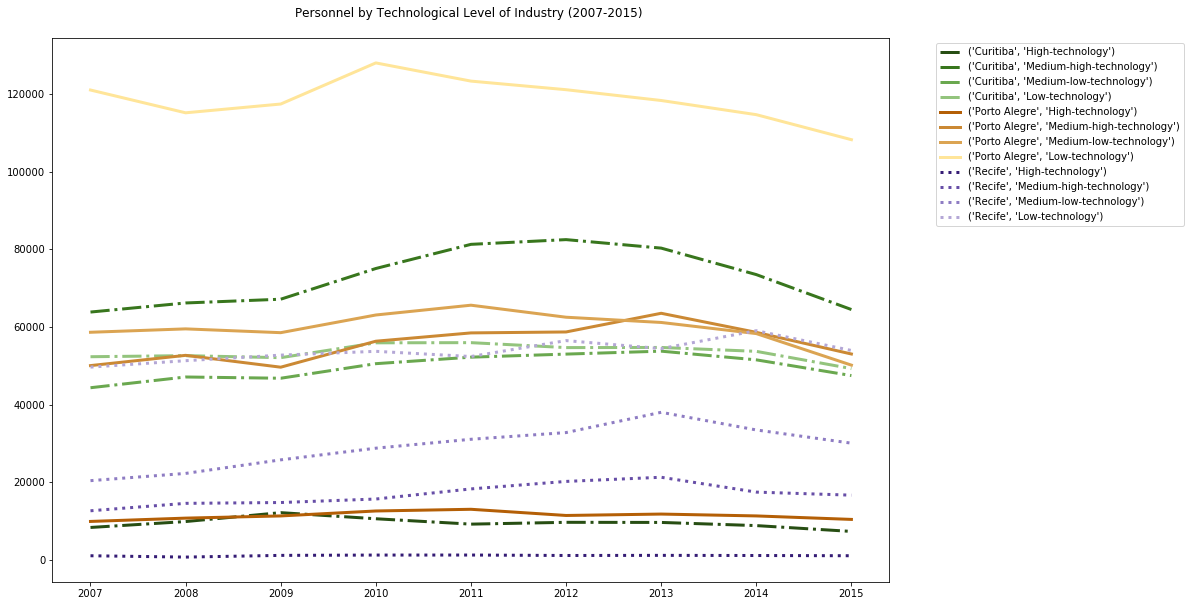

In [170]:
linestyles = ['-.','-.', '-.', '-.', 'solid', 'solid', 'solid', 'solid', 'dotted', 'dotted', 'dotted', 'dotted']

linecolors = ['#274E13','#38761D','#6AA84F','#93C47D', '#B45F06','#cb8934','#dba452','#FFE599','#351C75','#674EA7','#8E7CC3','#B4A7D6']

plt.figure(figsize=(15,10))
for i, linestyle, color in zip(range(len(df_aggregated.index)), linestyles, linecolors):
    plt.plot(df_aggregated.loc[df_aggregated.index[i]], color, linestyle=linestyle, linewidth=3)
plt.legend(df_aggregated.index,  loc='upper left', bbox_to_anchor=(1.05, 1));
plt.title('Personnel by Technological Level of Industry (2007-2015) \n');

In [171]:
#### df_aggregated['2007 a 2009 (%)'] = ((df_aggregated[2009] / df_aggregated[2007] - 1) * 100).values
df_aggregated['2009 a 2011 (%)'] = ((df_aggregated[2011] / df_aggregated[2009] - 1) * 100).values
df_aggregated['2011 a 2013 (%)'] = ((df_aggregated[2013] / df_aggregated[2011] - 1) * 100).values
df_aggregated['2013 a 2015 (%)'] = ((df_aggregated[2015] / df_aggregated[2013] - 1) * 100).values

df_aggregated

2007    2008    2009    2010    2011  \
             technology_industries                                            
Curitiba     High-technology           8395    9918   12211   10637    9252   
             Medium-high-technology   63875   66214   67181   75092   81313   
             Medium-low-technology    44384   47149   46828   50578   52256   
             Low-technology           52369   52644   52124   55949   55994   
Porto Alegre High-technology           9946   10800   11365   12640   13076   
             Medium-high-technology   50084   52725   49673   56364   58504   
             Medium-low-technology    58667   59540   58564   63117   65639   
             Low-technology          121061  115191  117451  128042  123355   
Recife       High-technology           1109     764    1205    1286    1293   
             Medium-high-technology   12693   14606   14817   15718   18323   
             Medium-low-technology    20450   22316   25808   28814   31108   
             Low-technology           49695   51346   52779   53760   52423   

                                       2012    2013    2014    2015  \
             technology_industries                                    
Curitiba     High-technology           9720    9689    8875    7374   
             Medium-high-technology   82530   80342   73523   64522   
             Medium-low-technology    53044   53802   51566   47512   
             Low-technology           54721   54757   53753   49313   
Porto Alegre High-technology          11484   11845   11367   10470   
             Medium-high-technology   58747   63558   58647   53070   
             Medium-low-technology    62543   61194   58330   50203   
             Low-technology          121142  118362  114712  108268   
Recife       High-technology           1177    1210    1172    1113   
             Medium-high-technology   20253   21323   17501   16713   
             Medium-low-technology    32834   38056   33509   30104   
             Low-technology           56522   54459   59074   53979   

                                     2009 a 2011 (%)  2011 a 2013 (%)  \
             technology_industries                                      
Curitiba     High-technology                  -24.23             4.72   
             Medium-high-technology            21.04            -1.19   
             Medium-low-technology             11.59             2.96   
             Low-technology                     7.42            -2.21   
Porto Alegre High-technology                   15.05            -9.41   
             Medium-high-technology            17.78             8.64   
             Medium-low-technology             12.08            -6.77   
             Low-technology                     5.03            -4.05   
Recife       High-technology                    7.30            -6.42   
             Medium-high-technology            23.66            16.37   
             Medium-low-technology             20.54            22.34   
             Low-technology                    -0.67             3.88   

                                     2013 a 2015 (%)  
             technology_industries                    
Curitiba     High-technology                  -23.89  
             Medium-high-technology           -19.69  
             Medium-low-technology            -11.69  
             Low-technology                    -9.94  
Porto Alegre High-technology                  -11.61  
             Medium-high-technology           -16.50  
             Medium-low-technology            -17.96  
             Low-technology                    -8.53  
Recife       High-technology                   -8.02  
             Medium-high-technology           -21.62  
             Medium-low-technology            -20.90  
             Low-technology                    -0.88

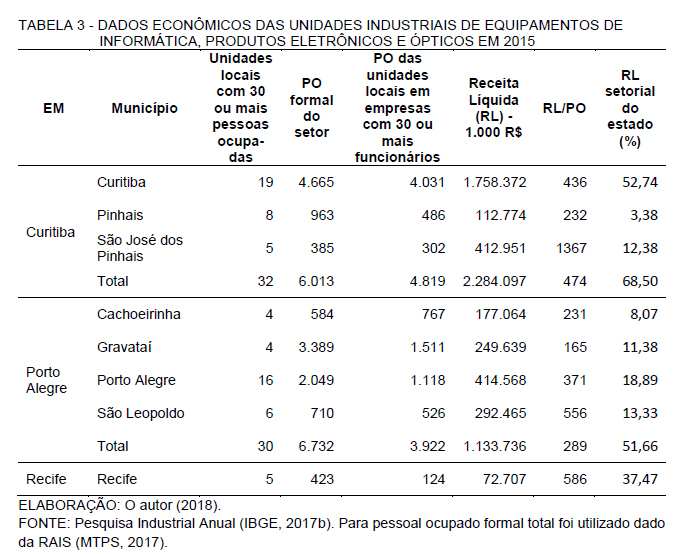

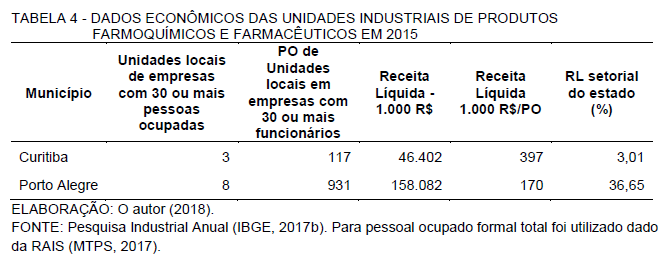

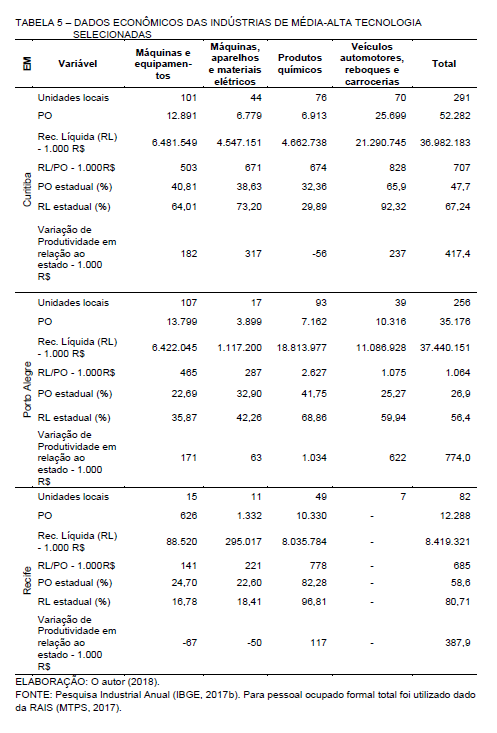